<a href="https://colab.research.google.com/github/jeenchun/Python-Project/blob/master/Copy_of_RKI_Data_Vis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scraping Robert-Koch-Institut Data on Corona-related developments in Germany

In [ ]:
# Import required packages
from bs4 import BeautifulSoup as bs
import requests
import csv

#get source code of website
source = requests.get("https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Fallzahlen.html").text
soup = bs(source, "lxml")

# create csv-file
csv_file = open("RKI_data.csv", "w")
csv_writer = csv.writer(csv_file, delimiter=",")
csv_writer.writerow(["Federal State", "Case Numbers", "Daily Difference", "Cases/100.000 Inh.", "Cases of Death"])

# parsing information
table=soup.find("table")

for bundesland in table.tbody.find_all("tr"):
  name = bundesland.find("td", colspan="1").text
  if name=="Gesamt":
    name="Total"
  print(name)

  numbers_abs = bundesland.find("td", class_="center").text
  print(numbers_abs)

  difference = bundesland.find_all("td", class_="center")[1].text
  print(difference)

  cases_100 = bundesland.find_all("td", class_="center")[2].text
  print(cases_100)

  death_cases =  bundesland.find_all("td", class_="center")[3].text
  print(death_cases)

  print()

  csv_writer.writerow([name, numbers_abs, difference, cases_100, death_cases])

csv_file.close()

# To Do:
# - decide on file format (csv/xlsx)
# - fix xlsx output
# - create an automatic, daily update function


Baden-Württem­berg*


AttributeError: ignored

In [ ]:
#visualising with pandas (Table)
import pandas as pd
df = pd.read_csv('RKI_data.csv', thousands='.', decimal=',')

#Deleting "Total" row for better visualization in further steps 
df = df.drop(df.index[16])
df.at[0, 'Federal State'] = 'Baden-Württemberg'
df.at[7, 'Federal State'] = 'Mecklenburg-Vorpommern'
df.at[9, 'Federal State'] = 'Nordrhein-Westfalen'
df.at[10, 'Federal State'] = 'Rheinland-Pfalz'
df.at[14, 'Federal State'] = 'Schleswig-Holstein'

#changing the decimal points from European to Global
format_dict = {'Mes':'{:%m-%Y}'} 
df.head(17).style.format(format_dict).highlight_max(color='#ff0000').highlight_min(color='darkgreen')

,Federal State,Case Numbers,Daily Difference,Cases/100.000 Inh.,Cases of Death
0,Baden-Württemberg,33359,+169*,301,1568
1,Bayern,44593,+225,341,2182
2,Berlin,6274,+2,167,165
3,Brandenburg,3111,+5,124,136
4,Bremen,1058,+3,155,35
5,Hamburg,4960,+180*,269,216
6,Hessen,9031,+19,144,415
7,Mecklenburg-Vorpommern,729,+1,45,20
8,Niedersachsen,10895,+41,136,507
9,Nordrhein-Westfalen,35333,+201,197,1456


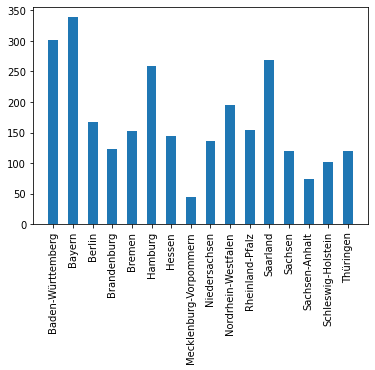

In [ ]:
#visualizing with Matplotlib bar graph

import matplotlib.pyplot as plt
plt.bar(df['Federal State'], df['Cases/100.000 Inh.'], width=0.5)
plt.xticks(rotation=90)
plt.savefig('BarGraph.png', format='png')

In [ ]:
#Map Visualization Solution using GeoPandas
!pip install geopandas
!pip install PyDrive

     |████████████████████████████████| 931kB 7.6MB/s 
     |████████████████████████████████| 10.9MB 27.1MB/s 
     |████████████████████████████████| 14.7MB 249kB/s 


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1fxcuVx37Nt5WGm8GxsM35Z3JUy3CPslI"})  
downloaded.GetContentFile('plz-gebiete.shp')

downloaded = drive.CreateFile({'id':"1v8e1S-0JYL0GaxcjNa1IDizmCYtbe58w"})  
downloaded.GetContentFile('plz-gebiete.dbf')    

downloaded = drive.CreateFile({'id':"1hAK9X00tcc99l782cEVYMRHFvBS0RjzO"})  
downloaded.GetContentFile('plz-gebiete.prj')    

downloaded = drive.CreateFile({'id':"1dQL38NfzQr0jg02sGFeM3-n_ORYx_7gl"})  
downloaded.GetContentFile('plz-gebiete.shx')   

downloaded = drive.CreateFile({'id':"1uKWuxX65MaugCEWf6fTfSDEZX7imHQQN"})  
downloaded.GetContentFile('zuordnung_plz_ort.csv')  



In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn')
%matplotlib inline

df = pd.read_csv('RKI_data.csv', thousands='.', decimal=',', dtype = {'Federal State':str})
df = df.drop(df.index[16])
df.at[0, 'Federal State'] = 'Baden-Württemberg'
df.at[7, 'Federal State'] = 'Mecklenburg-Vorpommern'
df.at[9, 'Federal State'] = 'Nordrhein-Westfalen'
df.at[10, 'Federal State'] = 'Rheinland-Pfalz'
df.at[14, 'Federal State'] = 'Schleswig-Holstein'

#df['longitude'] = [8.243008, 11.4979, 13.4050, 12.5316444, 8.8017, 9.9937, 9.1624, 12.4296, 9.8451, 7.6616, 7.3090, 7.0230, 13.2017, 11.6923, 9.6961, 10.8453]
#df['latitude'] = [48.758339, 48.7904, 52.5200, 52.4125287, 53.0793, 53.5511, 50.6521, 53.6127, 52.6367, 51.4332, 50.1183, 49.3964, 51.1045, 51.9503, 54.2194, 51.0110]

dmap = gpd.read_file('plz-gebiete.shp', dtype={'plz': str})
dmap.columns = ['plz', 'city', 'geometry']

plt.rcParams['figure.figsize'] = [16,11]

fig, ax = plt.subplots()
dmap.plot(ax=ax, color='orange', alpha=0.8)

laender = {
    'Baden-Württemberg': (8.243008, 48.758339), 
    'Bayern': (11.4979, 48.7904),
    'Berlin': (13.4050, 52.5200),
    'Brandenburg': (12.5316444, 52.4125287),
    'Bremen': (8.8017, 53.0793),
    'Hamburg': (9.9937, 53.5511),
    'Hessen': (9.1624, 50.6521),
    'Mecklenburg-Vorpommern': (12.4296, 53.6127),
    'Niedersachsen': (9.8451, 52.6367),
    'Nordrhein-Westfalen': (7.6616, 51.4332),
    'Rheinland-Pfalz': (7.3090, 50.1183),
    'Saarland': (7.0230, 49.3964),
    'Sachsen': (13.2017, 51.1045),
    'Sachsen-Anhalt': (11.6923, 51.9503),
    'Schleswig-Holstein': (9.6961, 54.2194),
    'Thüringen': (10.8453, 51.0110),
}

#Plot laender 
for c in laender.keys():
    # Plot city name.
    ax.text(
        x=laender[c][0], 
        y=laender[c][1] + 0.08, 
        s=c, 
        fontsize=12,
        ha='center', 
    )

    ax.plot(
            laender[c][0], 
            laender[c][1], 
            marker='o',
            c='black', 
            alpha=0.5
        )
    ax.set(
        title='Germany', 
        aspect=1.3, 
        facecolor='lightblue'
    );
plt.close(fig)
plt.savefig('GermanMap.png', format='png')

<Figure size 1152x792 with 0 Axes>

In [ ]:
#Mapping each postal code to corresponding region
zu = pd.read_csv('zuordnung_plz_ort.csv', 
                 sep = ',',
                 dtype = {'plz':str, 'bundesland':str})

germany_df = pd.merge(
    left = dmap, 
    right = zu,
    on = 'plz',
    how = 'left'
)

germany_df.columns = ['plz', 'city', 'geometry', 'osm_id','ort','Federal State']

In [ ]:
#Merging with RKI data
final = pd.merge(
    left = df, 
    right = germany_df,
    on='Federal State',
    how='right'
)

#SO I THINK THE BIGGEST ERROR IS THAT HERE AFTER THE MERGE, SOMEHOW THE DATAFRAME
# IS NO LONGER PLOTTED AS A MAP WHEN RUNNING final.plot( )

final2 = final.set_geometry('geometry')

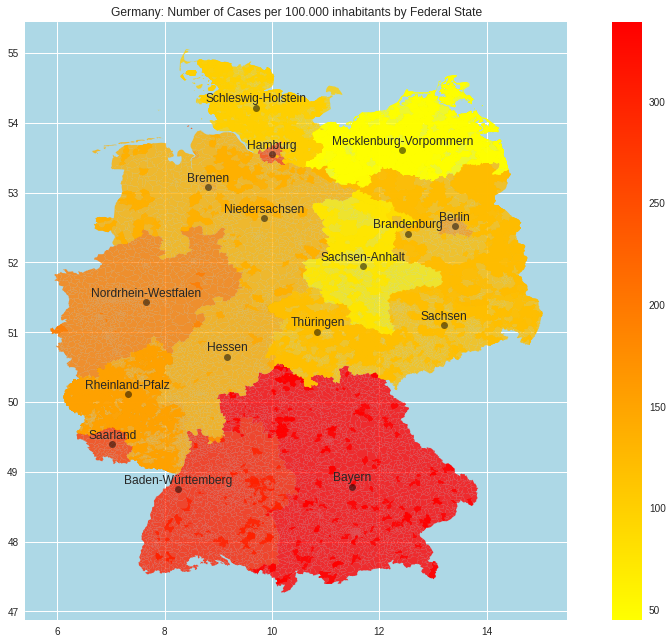

In [ ]:
#THIS IS THE PART WHERE THE HEATMAP SHOULD CREATE
fig, ax = plt.subplots()

final2.plot(
    ax=ax, 
    column='Cases/100.000 Inh.', 
    categorical=False, 
    legend=True, 
    cmap='autumn_r',
    alpha=0.8
)

for c in laender.keys():

    ax.text(
        x=laender[c][0], 
        y=laender[c][1] + 0.08, 
        s=c, 
        fontsize=12,
        ha='center', 
    )

    ax.plot(
        laender[c][0], 
        laender[c][1], 
        marker='o',
        c='black', 
        alpha=0.5
    )
    
ax.set(
    title='Germany: Number of Cases per 100.000 inhabitants by Federal State', 
    aspect=1.3, 
    facecolor='lightblue'
);

plt.savefig('HeatMap.png', format='png')